# Predicting Ocean Surface Windspeed from CYGNSS Satellite GPS Signals DDM, using Convolutional Neural Networks (CNN) 

## Author: IFEANYI INNOCENT OKARO


# INTRODUCTION

The CYGNSS Satellite launched in 2016, measures the strength of GPS signals reflected by the ocean floor. This gives additional information on the surface. Notably, The roughness of the ocean surface is presumed to be related to the windspeed. This is used to forecast extreme weather conditions like tropical cyclones. The aim of this project is to establish this relationship by using Artificial Neural Networks. A subset of the Delay Doppler Measurment Map (DDM) given by the bin bistatic radar cross section (brcs), from CYGNSS data and the Windspeed Data from ERA5 will be used for this excercise.

In [1]:
import numpy as  np
import pandas as pd
import cv2
import netCDF4
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt

# Exploring the data

I will leverage on the xarray library in Python which combines the power of numpy and pandas to explore the data.

In [2]:
# reading the dataset
Dt = xr.open_dataset('cygnss_testdata.nc') 

print(Dt.var)
print(Dt.dims)
print(Dt.coords)
print(Dt.attrs)

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:            (delay: 17, doppler: 11, sd: 430959)
Dimensions without coordinates: delay, doppler, sd
Data variables:
    spacecraft_id      (sd) int16 ...
    spacecraft_num     (sd) int8 ...
    delay_resolution   (sd) float32 ...
    zenith_code_phase  (sd) float32 ...
    brcs               (sd, delay, doppler) float32 ...
    windspeed          (sd) float64 ...
    quality            (sd) int32 ...>
Frozen(SortedKeysDict({'sd': 430959, 'delay': 17, 'doppler': 11}))
Coordinates:
    *empty*
{}


The image data is stored in the 2 dimensional variable 'brcs' while the Windspeed data is stored in 'windspead', I will extract these two varibles to obtain their properties.

In [3]:
# brcs  data
brcs = Dt['brcs']
print(brcs.shape)
brcs.head()

(430959, 17, 11)


<xarray.DataArray 'brcs' (sd: 5, delay: 5, doppler: 5)>
array([[[-4.707013e+08, -3.442318e+07, -3.442318e+07, -4.707013e+08,
         -4.707013e+08],
        [-6.888403e+08, -4.707013e+08,  1.837159e+08, -3.442318e+07,
         -6.888403e+08],
        [-1.343257e+09, -6.888403e+08,  4.018549e+08,  1.837159e+08,
         -4.707013e+08],
        [-1.343257e+09, -9.069794e+08,  1.837159e+08,  4.018549e+08,
          1.837159e+08],
        [-9.069794e+08, -4.707013e+08, -3.442318e+07,  6.199940e+08,
          1.492550e+09]],

       [[ 1.204650e+08,  1.204650e+08,  1.204650e+08, -3.159469e+08,
         -3.159469e+08],
        [-9.774094e+07,  3.386710e+08,  5.568770e+08, -9.774094e+07,
         -3.159469e+08],
        [-3.159469e+08,  1.204650e+08,  3.386710e+08, -9.774094e+07,
         -9.774094e+07],
        [-3.159469e+08,  1.204650e+08, -9.774094e+07,  1.204650e+08,
         -9.774094e+07],
        [-5.341529e+08, -9.774094e+07, -3.159469e+08,  3.386710e+08,
          9.932890e+08]],

       [[          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan]],

       [[          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan]],

       [[          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan],
        [          nan,           nan,           nan,           nan,
                   nan]]], dtype=float32)
Dimensions without coordinates: sd, delay, doppler
Attributes:
    long_name:    DDM bin bistatic radar cross section
    coordinates:  ddm_timestamp_utc sp_lat sp_lon
    units:        meter2
    comment:      17 x 11 array of DDM bin bistatic radar cross section, m^2....

In [4]:
# windspeed data
windspeed = Dt['windspeed']
print(windspeed.shape)
windspeed.head()

(430959,)


<xarray.DataArray 'windspeed' (sd: 5)>
array([7.711892, 7.711892, 7.41991 , 7.41991 , 7.41991 ])
Dimensions without coordinates: sd

Having accesed the 1 dimension windspeed data and a 2D image data. In the next steps I will explore the data futher and find the possible relationship.

# Visualizing the data

We can see that the windspeed is a one dimensional array while brcs brcs is a 2 dimensional array. We will visualize some part of the data to understand it better. 

## Windspeed data
To explore the windspeed data, 5000 data points repesenting the most recent data was visualizes in a graph. 

Text(0, 0.5, 'Windspeed (m/s)')

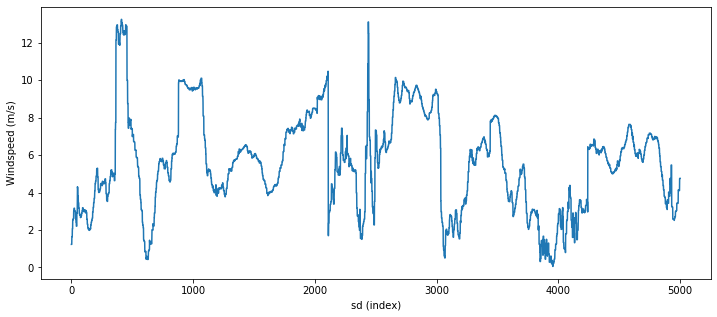

In [5]:
# plotting the data
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(windspeed.tail(5000))
plt.xlabel('sd (index)')
plt.ylabel('Windspeed (m/s)')

We can see the fluctuations and from 0 to 16m/s

## Delay Doppler Map (DDM)
This is a 2D Image which can be visualized either individually or by finding the mean of all readings at a particular point. It represents the response recieved by the radar scanning the ocean floor. for visualization, some of the images were randomly visualized with the corresponding windspeed.

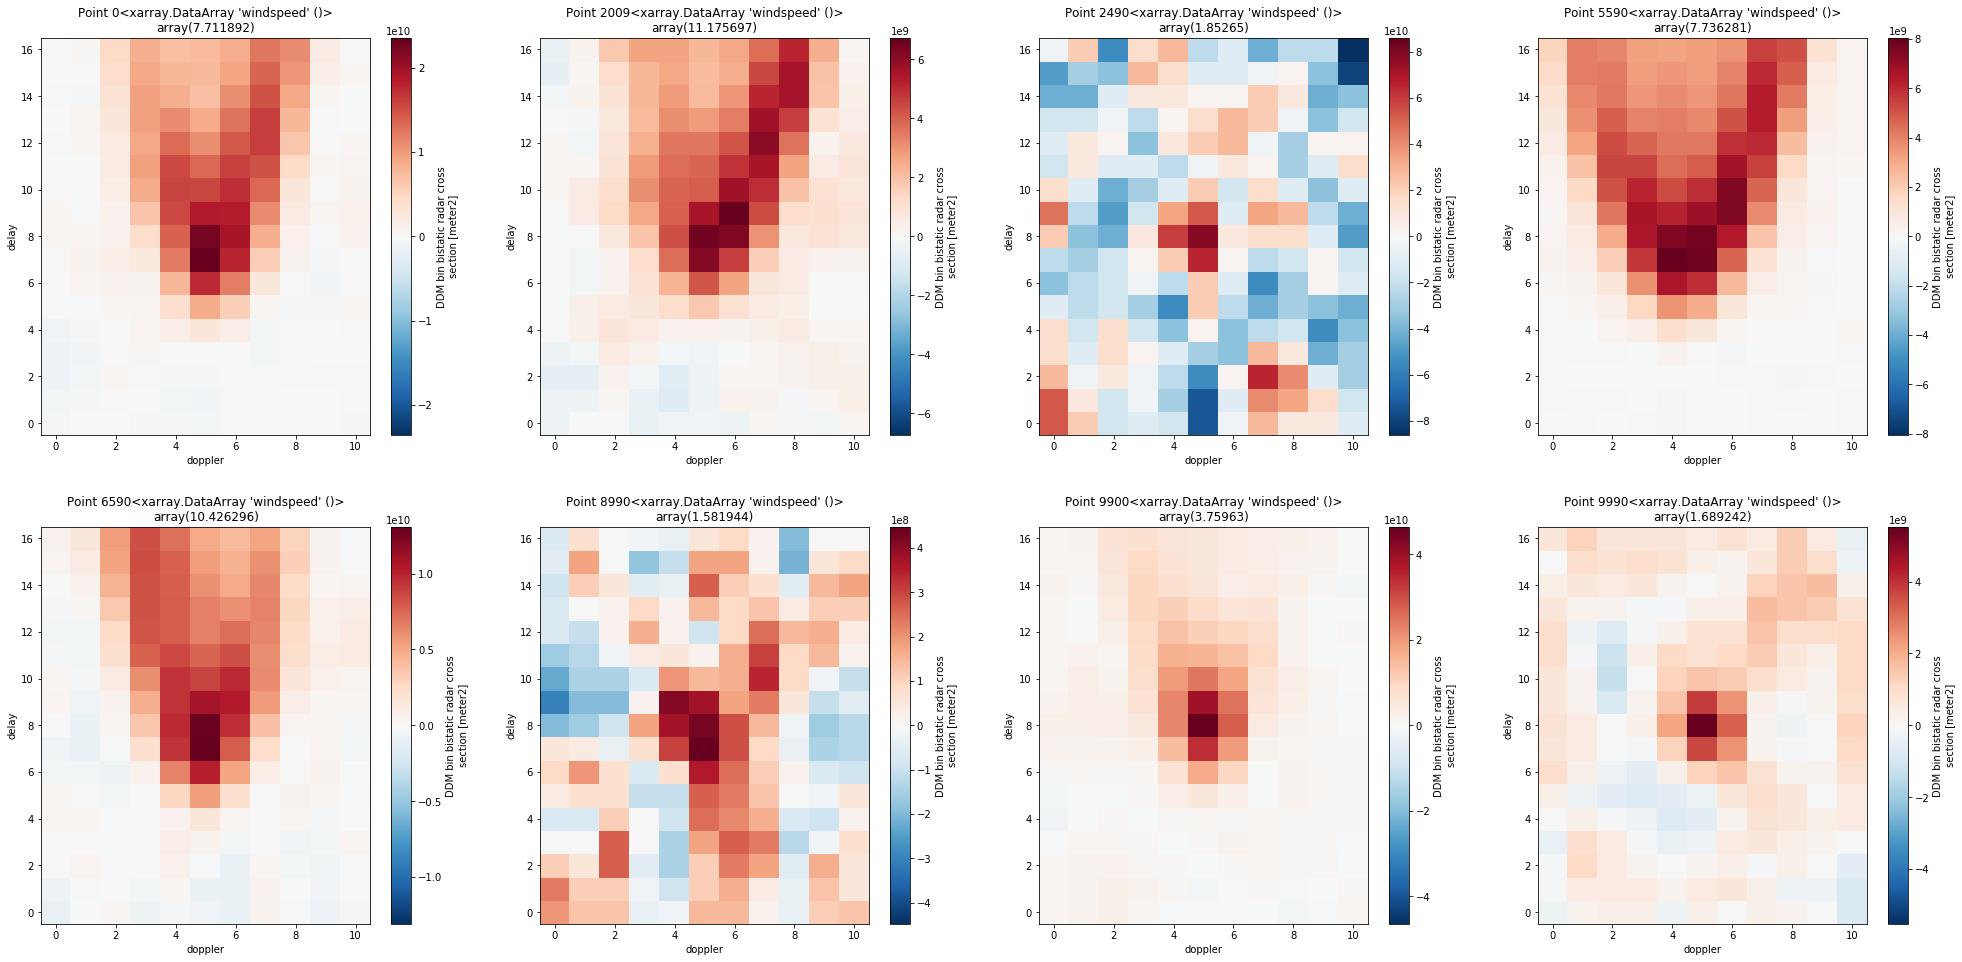

In [6]:
# We create subplots for 8 random picks from our data
plt.rcParams['figure.figsize'] = [28, 14]
fig, axes = plt.subplots(ncols = 4, nrows = 2)

brcs[0].plot(ax = axes[0,0])
axes[0,0].set_title('Point 0'+ str(windspeed[0]))

brcs[2009].plot(ax = axes[0,1])
axes[0,1].set_title('Point 2009' + str(windspeed[2009]))

brcs[2490].plot(ax = axes[0,2]) 
axes[0,2].set_title('Point 2490'+ str(windspeed[2490]))

brcs[5590].plot(ax = axes[0,3])
axes[0,3].set_title('Point 5590' + str(windspeed[5590]))

brcs[6590].plot(ax = axes[1,0])
axes[1,0].set_title('Point 6590' + str(windspeed[6590]))

brcs[8990].plot(ax = axes[1,1])
axes[1,1].set_title('Point 8990'+ str(windspeed[8990]))

brcs[9900].plot(ax = axes[1,2]) 
axes[1,2].set_title('Point 9900'+ str(windspeed[9900]))

brcs[9990].plot(ax = axes[1,3])
axes[1,3].set_title('Point 9990'+ str(windspeed[9990]))

fig.tight_layout(pad=3.0)

From The images we could already see that there seems to be a relationship between windspeed and DDM. A high value of windspeed corresponds with a curved reflectance with the sharpest point at the middle, presumably, the place directly in the line of sight of the radar. this may be caused by dispersal of signals by wind. A lower windspeed corresponds with images having different brcs values with some values in the negative. This needs to be analysed futher.


We will look at some of our image parameters in a 1 D plot and also explore some statistics. 

/Users/ifeanyi/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ifeanyi/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/ifeanyi/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'brsc at std delay-doppler')

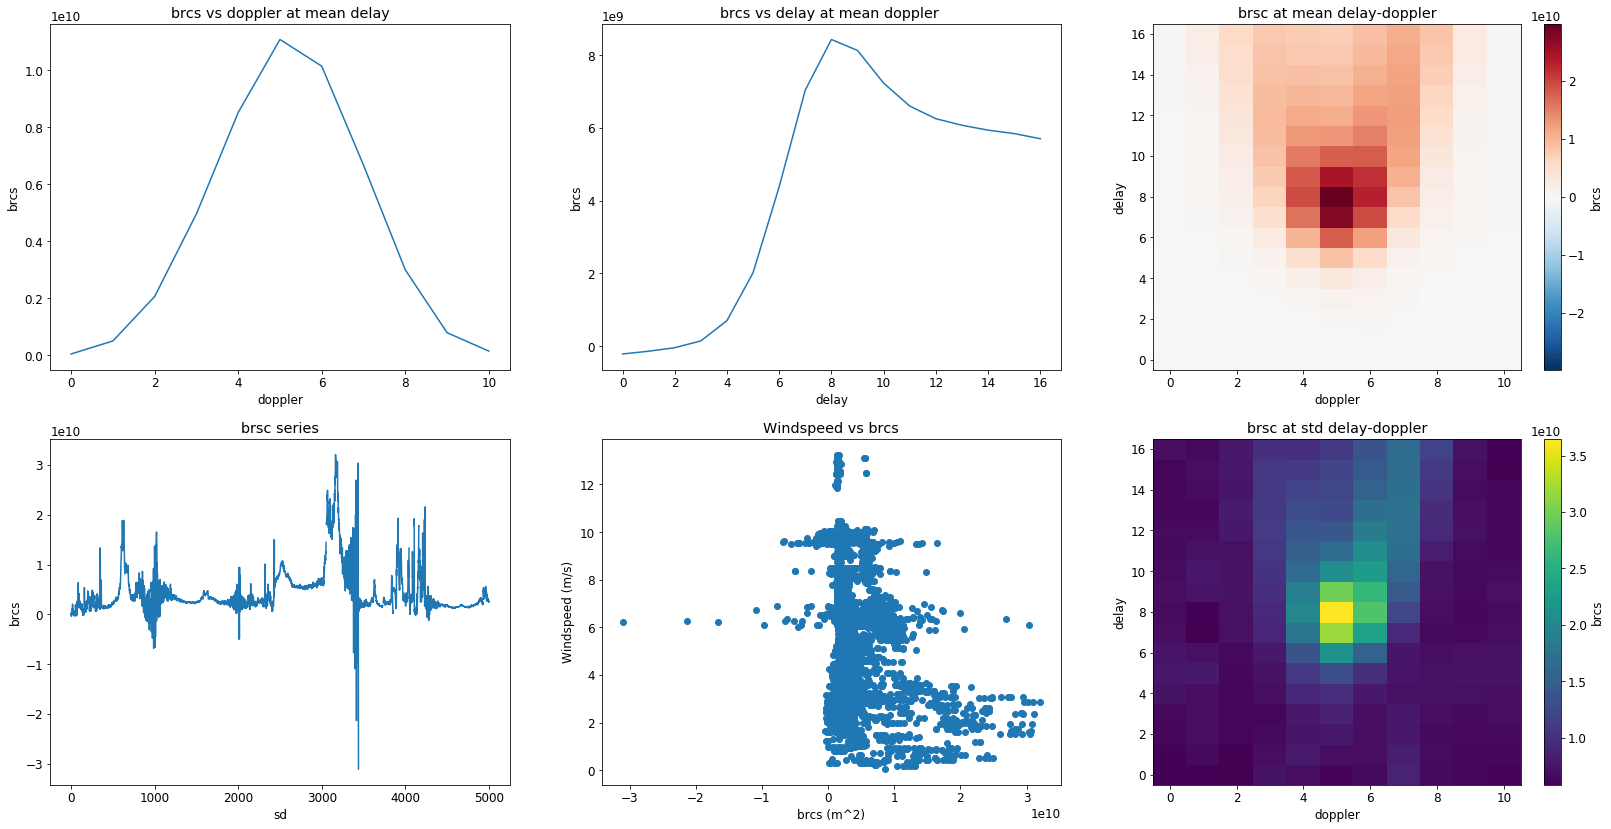

In [7]:
# We set some parameters for ploting
font = {'family' : 'DejaVu Sans',
        'weight' : 'light',
        'size'   : 12}
plt.rc('font', **font)
# We plot our image in 2D
plt.rcParams['figure.figsize'] = [28, 14]
fig, axes = plt.subplots(ncols = 3, nrows = 2)

brcs.tail(5000).mean(axis = 1).mean(axis = 0).plot(ax = axes[0,0])
axes[0,0].set_title('brcs vs doppler at mean delay')

brcs.tail(5000).mean(axis = 0).mean(axis= 1).plot(ax = axes[0,1])
axes[0,1].set_title('brcs vs delay at mean doppler ')

brcs.tail(5000).mean(axis = 0).plot(ax = axes[0,2]) 
axes[0,2].set_title('brsc at mean delay-doppler')

brcs.tail(5000).mean(axis = 1).mean(axis= 1).plot(ax = axes[1,0])
axes[1,0].set_title('brsc series')

# We scatter the windspead against image mean again
brcs_points = brcs.tail(5000).mean(axis = 2).mean(axis=1)
axes[1,1].scatter(brcs_points,windspeed.tail(5000))
axes[1,1].set_title('Windspeed vs brcs')
axes[1,1].set_xlabel('brcs (m^2)')
axes[1,1].set_ylabel('Windspeed (m/s)')

brcs.tail(5000).std(axis = 0).plot(ax = axes[1,2]) 
axes[1,2].set_title('brsc at std delay-doppler')

We can observe that the brcs vs doppler is symetrical distribution, while the brcs delay map is negatively skewed. The brcs has more concentration near 0 with a few spikes. Our Windspeed vs brsc plot shows that most values are spread towards the positive at low windspeed and get narrower towards the center (0) at higher windspeed. The brsc represents how detectable an object is by radar. A high brsc represents stronger radar response from the object. This graph shows that at lower windspeed, the radar response is generally stronger while at higher windspeed above 10m/s, only a small response is recieved. This corresponds with our observation from the images plotted early. 

This means that, the higher the windspeed, the lower the radar response. However, this is not a very linear relationship. Other factors could also affect brcs such as the type of material, Incident angle, the wavelenght or streght of radar signat, etc. There is also an amomaly at windspeed of about 6m/s. This will need to be studied more for better understand.

# Machine learning - Convolutional Neural Networks (CNN)
We try to predict the windspeed using the shape of the image from the brcs. We will train the model to recognise the greyscale images particularly the shape of the peak responses, and predict the value of the correspending windspeed related to that. This will be done with 5000 - 6000 points for the purpose of demonstration. We will be using mainly Keras framework for this.

In [469]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

The next step is to create the CNN architecture for our data using the Keras framework.

In [470]:
def windspeed_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    """ CNN model for predicting windspeed"""
    # we define the shape of the input
    image_Shape = (width, height, depth)
    chanDim = -1
    # define the input for the model
    inputs = Input(shape=image_Shape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        if i == 0:
            img = inputs
        # CONV => RELU => BN => POOL
        img = Conv2D(f, (3, 3), padding="same")(img)
        img = Activation("relu")(img)
        img = BatchNormalization(axis=chanDim)(img)
        img = MaxPooling2D(pool_size=(2, 2))(img)
        
        # flattening the volume, applying FC => RELU => BN => DROPOUT
        img = Flatten()(img)
        img = Dense(64)(img)
        img = Activation("relu")(img)
        img = BatchNormalization(axis=chanDim)(img)
        img = Dropout(0.5)(img)
        # we apply another FC layer
        img = Dense(16)(img)
        img = Activation("relu")(img)
        # check to see if the regression node should be added
        if regress:
            img = Dense(1, activation="linear")(img)
        # building the CNN model
        model = Model(inputs, img)
        # return the model
        return model

We will define the imputs that will go into our CNN in the next steps. The imputs will be rescaled for more effective learning. I will be dropping the NaN values in the image array because these values do not contain any information. We can interpolate it but then, that will generate an entirely new image which may likely not correspond with our windspeed value. We will select corresponding data for both dataarrays by indexing with the NaN mask from the image data.

In [266]:
# We define function to help us process the data
def process_training_input(image_array, windspeed_array):
    """ This processes imput data frame to drop nan from image data"""
    """ This selects corresponding image and windspeed data"""
    """ and rescale data for improved learning by the CNN"""
    indx = []
    for i in range(len(image_array)):
        if np.isfinite(image_array[i][1][1]):
            indx.append(i)
            
    image_array = np.expand_dims(image_array, axis=3)
    image_array = image_array[indx]
    windspeed_array = windspeed_array[indx]
                           
    return image_array , windspeed_array

We will now apply this function on a subset of our data which we will use for this excercise.

In [466]:
# we create the subset and apply our function
image_set = brcs.tail(6000)
wind_set = windspeed.tail(6000)
images, wspeed = process_training_input(image_set, wind_set)
print(images.shape)
print(wspeed.shape)
print(wspeed.max())
print(wspeed.min())

(5592, 17, 11, 1)
(5592,)
<xarray.DataArray 'windspeed' ()>
array(13.24674388)
<xarray.DataArray 'windspeed' ()>
array(0.05207494)


In [476]:
# we divide the data into train and test sets
split_data = train_test_split(wspeed, images, test_size=0.25, random_state=42)
(trainwindY, testwindY, trainImagesX, testImagesX) = split_data

# We normalizen/rescale the data
maxwind = wspeed.max()
trainwindY = trainwindY / maxwind
testwindY = testwindY / maxwind

We will create a CNN and compile. We will be using Adam optimizer for this. learning rate 0.001, decay 0.001. The model will run for 200 epochs. We will also evaluate with mean_absolute_percentage_error to check how much we minimized the absolute percentage difference between our predictions and given windspeed.

In [477]:
# we apply the earlier created model with Adam optimizer and set regress True
model = windspeed_cnn(17, 11, 1, regress=True)
Adam_opt = Adam(lr=0.001, decay=0.001 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=Adam_opt)

We fit the model and let it train for 200 epochs

In [478]:
# training the model
history = model.fit(trainImagesX, trainwindY, validation_data=(testImagesX, testwindY), epochs=200, batch_size=64)

Train on 4194 samples, validate on 1398 samples
Epoch 1/200
4194/4194 [==============================] - 1s 235us/step - loss: 321.6629 - val_loss: 184.0435
Epoch 2/200
4194/4194 [==============================] - 0s 105us/step - loss: 173.9565 - val_loss: 147.2890
Epoch 3/200
4194/4194 [==============================] - 0s 102us/step - loss: 134.5380 - val_loss: 96.1080
Epoch 4/200
4194/4194 [==============================] - 0s 103us/step - loss: 111.2645 - val_loss: 83.4342
Epoch 5/200
4194/4194 [==============================] - 0s 103us/step - loss: 99.9949 - val_loss: 96.7946
Epoch 6/200
4194/4194 [==============================] - 0s 102us/step - loss: 98.4933 - val_loss: 88.8675
Epoch 7/200
4194/4194 [==============================] - 0s 101us/step - loss: 85.4849 - val_loss: 87.1007
Epoch 8/200
4194/4194 [==============================] - 0s 100us/step - loss: 81.0999 - val_loss: 88.3506
Epoch 9/200
4194/4194 [==============================] - 0s 101us/step - loss: 71.7578 - v

In [479]:
# We predict the test data
#print(history.history.keys())
predictions = model.predict(testImagesX)

# we find the absolute percentage difference

percdiff_abs = np.abs(((predictions.flatten() - testwindY) / testwindY) * 100)


# compute the mean and standard deviation of the absolute percentage
print(np.mean(percdiff_abs))
print(np.std(percdiff_abs))

<xarray.DataArray 'windspeed' ()>
array(30.58694975)
<xarray.DataArray 'windspeed' ()>
array(48.88817235)


We obtained an mean absolute percentage loss of 30%. It will be nice to visualize the learning history in order to observe how the model performed

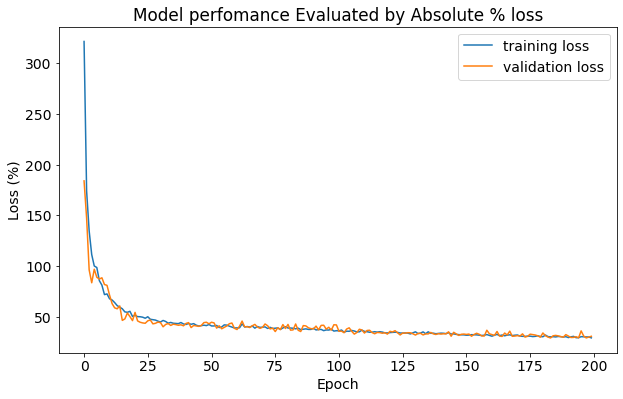

In [480]:
# "Loss Plot 
plt.rcParams['figure.figsize'] = [10, 6]
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model perfomance Evaluated by Absolute % loss')
plt.ylabel('Loss (%)')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

The model performed okay on the small sample size used. The range of windspeed in our sample data is from 0.05 - 13.2 m/s. Though for a better and more precise prediction, there will be need to conduct training on all the quality images that can be extracted from the data set. This will ofcourse take longer time and require higher computing power than what I have available at the moment due to the current situation. There could also be futher processing of the image enhance the visibility to our CNN. 

# CNN Categorical Clasification of Windspeed
We will like to classify the windspeed into 3 different classes "high", "medium" and "low" and see if CNN models will do better in predicting that. This could be useful in the area of predicting Cyclones. Generally cyclones are associated with high wind speed in the ocean. We will have to calliberate our sample Windspeed data and obtain a lebel for our classification. Then we try to associate it with corresponding images.

Our windspeed goes fro 0.05 to 13.2. we will set our first class "low" at ≤ 4,"medium" at ≤ 8 and high as > 8. 

In [289]:
from numpy import argmax
from numpy import array
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential

In [425]:
def categorize_windspeed(array):
    """ This will divide the windspeed into categores"""
    classes = []
    for i in range(len(array)):
        if array[i] <= 4:
            classes.append("low")
        elif array[i] > 4 and array[i]<= 8:
            classes.append("moderate")
        elif array[i]> 8:
            classes.append("high")
            
    return classes

We will apply the function and categorize our windspeed data. Then check the distribution 

In [438]:
# we apply our functions
cat = categorize_windspeed(wspeed)
from collections import Counter
labels = Counter(cat).keys() 
count = Counter(cat).values()

# we check the distribution
for i,j in zip(labels,count):
    print(i ,":",j)

moderate : 3040
high : 953
low : 1599


We can see that even though our classes are not evenly distributed, each class is still well represented in the sample. We split the data and apply encoding to enable us feed the categories into our model

In [453]:
# we divide the data into train and test sets
split_cat_data = train_test_split(cat, images, test_size=0.25, random_state=42)
(trainwindY, testwindY, trainImagesX, testImagesX) = split_cat_data

# We encode the category data
label_encoder = LabelEncoder()
trainY_code = label_encoder.fit_transform(trainwindY)
trainY = to_categorical(trainY_code)
testY_code = label_encoder.fit_transform(testwindY)
testY = to_categorical(testY_code)
print(testwindY[:4])
print(testY_code[:4])
print(argmax(testY[:4]))

['low', 'moderate', 'moderate', 'moderate']
[1 2 2 2]
1


We compile the model with CNN optimizer

In [454]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

def Windspeed_cnn_class(width, height, depth, classes):
    """This function builds the CNN mode for categoriesl"""
    
    # we initialize the model
    model = Sequential()
    inputShape2 = (width, height, depth)
    chanDim = -1

    #CONV => RELU => CONV => RELU => POOL layer 1
    model.add(Conv2D(32, (3, 3), padding="same",
        input_shape=inputShape2))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #CONV => RELU => CONV => RELU => POOL layer 2
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # FC => RELU layer
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the model
    return model

The model is optimised with SGD. Since it is a classification task, we will be checking for the accuracy.

In [455]:
# building the model
opt = SGD(lr=0.01, momentum=0.9, decay=0.01 / 100)
model2 = Windspeed_cnn_class(width=17, height=11, depth=1, classes=3)
model2.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [456]:
# We train the model
Hist = model2.fit(trainImagesX, trainY,validation_data=(testImagesX, testY),batch_size=32, epochs=100)

Epoch 1/100
132/132 [==============================] - 3s 26ms/step - loss: 1.5259 - accuracy: 0.5241 - val_loss: 1.7826 - val_accuracy: 0.6066
Epoch 2/100
132/132 [==============================] - 4s 28ms/step - loss: 1.3923 - accuracy: 0.6042 - val_loss: 1.2642 - val_accuracy: 0.6431
Epoch 3/100
132/132 [==============================] - 5s 35ms/step - loss: 1.2735 - accuracy: 0.6214 - val_loss: 1.5402 - val_accuracy: 0.6466
Epoch 4/100
132/132 [==============================] - 5s 36ms/step - loss: 1.5723 - accuracy: 0.5670 - val_loss: 1.7225 - val_accuracy: 0.6030
Epoch 5/100
132/132 [==============================] - 5s 36ms/step - loss: 1.3498 - accuracy: 0.6049 - val_loss: 0.9558 - val_accuracy: 0.6681
Epoch 6/100
132/132 [==============================] - 5s 39ms/step - loss: 1.4503 - accuracy: 0.6018 - val_loss: 0.9068 - val_accuracy: 0.7010
Epoch 7/100
132/132 [==============================] - 5s 41ms/step - loss: 1.1680 - accuracy: 0.6500 - val_loss: 0.8848 - val_accuracy:

We deploy our model to predict the test dataset.

In [457]:
preds = model2.predict(testImagesX)

print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1),target_names=labels))

              precision    recall  f1-score   support

    moderate       0.71      0.71      0.71       236
        high       0.90      0.77      0.83       397
         low       0.82      0.88      0.85       765

    accuracy                           0.82      1398
   macro avg       0.81      0.79      0.80      1398
weighted avg       0.82      0.82      0.82      1398



We plot our Accuracy and loss for visualisation.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


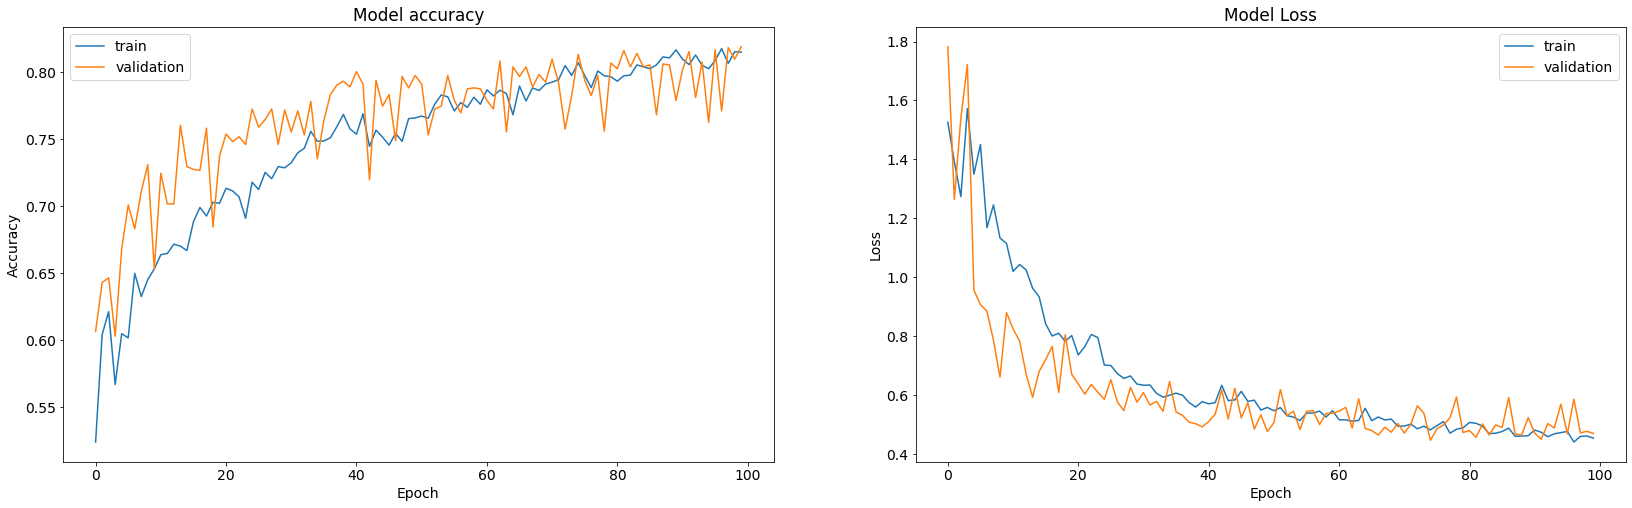

In [462]:
history = Hist
print(history.history.keys())

# We set some parameters for ploting
font = {'family' : 'DejaVu Sans',
        'weight' : 'light',
        'size'   : 14}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [28, 8]
f,ax = plt.subplots(1,2, sharex=False)
# Accuracy Plots
ax[0].plot(history.history['accuracy'], label = 'train')
ax[0].plot(history.history['val_accuracy'], label = 'validation')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
legend = ax[0].legend()

ax[1].plot(history.history['loss'], label = 'train')
ax[1].plot(history.history['val_loss'], label = 'validation')
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
legend = ax[1].legend()
plt.show()


From the graph we can see that our learning continued to improve up 75% accuracy. This however is not a very smoothing curve but it goes a long way to show that there is room for improving the model and making it perfectly fit.  The train loss curve however looks smoother. This may be because training loss is measured during each epoch while validation loss is measured after each epoch so there is sometimes this generalization gap in between the two losses. 

# SUMMARY

As observed from this excercise, the brightness and shape of the radar response is affectd by windspeed. This is as aresult of scattering from the wind induced rough ocean surface. The category model is useful for pleriminary monitoring of the windspeed behaviour. Such model can help in monitory a cyclone at earl stages and follow its developement. An early indication will help in exploring some other factors that could be responsible for the development and progression. The continous CNN model can be used to derive actual windspeed. This though is only possible when the model has been trained with very large dataset and validated. Futher studies will be required to fully understand this relationship. 


# References

* Ruf, Christopher & Gleason, Scott & Jelenak, Zorana & Katzberg, Stephen & Ridley, Aaron & Rose, Randall & Scherrer,    John & Zavorotny, Valery. (2013). The NASA Cyclone Global Navigation Satellite System (CYGNSS) Mission. IEEE    Aerospace Conference Proceedings. 4940-. 10.1109/AERO.2013.6497202. 

* The German Climate Computing Centre (DKRZ).